### The raw dataset represents community-level healthcare utilization across different Census Tracts

### Each row corresponds to a specific geopgraphic region and summarizes how  its residents use healthcare services.

### Census_tract is unique identifier for each geographic region and of categorical type, remaining all other are numeric type which shows their numbers in particular region.




# Purpose of the Dataset

### The dataset helps public health analysts and healthcare organizations:

### 1) Identify regions with high healthcare utilization (e.g., frequent ER visits)

### 2) Understand population-adjusted healthcare demand

### 3) Detect preventable conditions or inefficiencies (e.g., asthma-related ED visits instead of outpatient care)

### 4) Support targeted interventions and resource allocation (e.g., setting up community clinics)

# New Feature

### To make the data more comparable across census tracts of different population sizes, we engineered a new feature:

ED_visit_rate = (ED_visits/ Total_members) * 1000

### Meaning 
### This represents the number of emergency department visits per 1000 members in each census tract.

# Why it Matters??

### Normalization across population - Large and small census tracts can now be directly compared regardless of population size.

### Hotspot Identification - High ED_visit_rate regions may indicate poor access to primary care, social inequities or chronic condition burdens.

### Performance tracking - The metric can be monitored over time to measure the impact of interventions or policy chnages.

### Resource plannig - Helps hospitals and public health departments decide where to allocate additional ED resources or preventive care programs.

# In general

### A higher ED visit rate (i.e., more emergency visits per 1,000 members) generally indicates that people in that area rely more on the emergency department for healthcare services.

In [2]:
import pandas as pd

df=pd.read_csv("dataset_asthma-2017.csv")

In [3]:
df

,Census_tract,ED_visits,ED_hosp,UC_visits,Asthma_use,Total_members
0,42003010300,2,0,0,6,83
1,42003020100,32,19,3,223,2114
2,42003020300,0,0,0,2,48
3,42003030500,11,3,3,61,422
4,42003040200,2,1,1,18,138
...,...,...,...,...,...,...
393,42003980600,0,0,0,0,5
394,42003980700,0,0,0,1,2
395,42003981000,0,0,0,0,8
396,42003981800,0,0,0,0,13


In [9]:
import numpy as np

#quick clean of whitespace column names

df.columns = df.columns.str.strip()

#ensure numeric types
num_cols =['ED_visits', 'ED_hosp', 'UC_visits', 'Asthma_use', 'Total_members']
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')


In [10]:
#Data quality checks(basics)

#overview
print(df.shape)
display(df.head())
df.info()

#missing counts
print(df[num_cols].isnull().sum())

#basic descriptive stats

display(df[num_cols].describe())

#check zeros in Total_members (dangerous as denominator)
print("Total_members == 0 count:", (df['Total_members'] == 0).sum())

(398, 6)


,Census_tract,ED_visits,ED_hosp,UC_visits,Asthma_use,Total_members
0,42003010300,2,0,0,6,83
1,42003020100,32,19,3,223,2114
2,42003020300,0,0,0,2,48
3,42003030500,11,3,3,61,422
4,42003040200,2,1,1,18,138


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Census_tract   398 non-null    int64
 1   ED_visits      398 non-null    int64
 2   ED_hosp        398 non-null    int64
 3   UC_visits      398 non-null    int64
 4   Asthma_use     398 non-null    int64
 5   Total_members  398 non-null    int64
dtypes: int64(6)
memory usage: 18.8 KB
ED_visits        0
ED_hosp          0
UC_visits        0
Asthma_use       0
Total_members    0
dtype: int64


,ED_visits,ED_hosp,UC_visits,Asthma_use,Total_members
count,398.000000,398.000000,398.000000,398.000000,398.000000
mean,3.241206,1.628141,0.645729,38.211055,466.160804
std,3.867726,2.520927,0.997538,26.692213,295.714154
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,0.000000,0.000000,20.000000,249.500000
50%,2.000000,1.000000,0.000000,35.000000,412.000000
75%,4.000000,2.000000,1.000000,53.000000,646.750000
max,32.000000,19.000000,6.000000,240.000000,2398.000000


Total_members == 0 count: 0


In [12]:
#drop rows where Total_members is missing or <=0 because rates would be invalid
df = df[(df['Total_members'].notna()) & (df['Total_members'] > 0)] .copy()

#For other numeric NaNs, if small percent:
df[num_cols].isna().sum() #inspect

# fill remaining visit NaNs with 0 if appropriate:
df[['ED_visits', 'ED_hosp', 'UC_visits', 'Asthma_use']] = df[['ED_visits','ED_hosp','UC_visits','Asthma_use']].fillna(0)

In [13]:
#rates per 1000 members
df['ED_visit_rate'] =df['ED_visits']/ df['Total_members'] * 1000
df['ED_hosp_rate'] =df['ED_hosp'] / df['Total_members'] * 1000
df['UC_visit_rate'] =df['UC_visits'] / df['Total_members'] * 1000
df['Asthma_use_rate'] = df['Asthma_use'] / df['Total_members'] * 1000

#ratios to understand mix 
eps = 1e-6
df['ED_to_UC_ratio'] =df['ED_visits'] / (df['UC_visits'] + eps)
df['ED_hosp_to_ED_ratio'] =df['ED_hosp'] / (df['ED_visits'] + eps)
df['Asthma_to_ED_ratio'] = df['Asthma_use'] / (df['ED_visits'] +eps)

#combined engagement metric(example)
df['Total_encounters'] =df['ED_visits'] + df ['UC_visits'] +df['Asthma_use']
df['Encounters_per_1000'] =df['Total_encounters'] / df['Total_members'] * 1000

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4556\1876278443.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df['ED_visit_rate'].dropna(), df['UC_visit_rate'].dropna(), df['Asthma_use_rate'].dropna()],


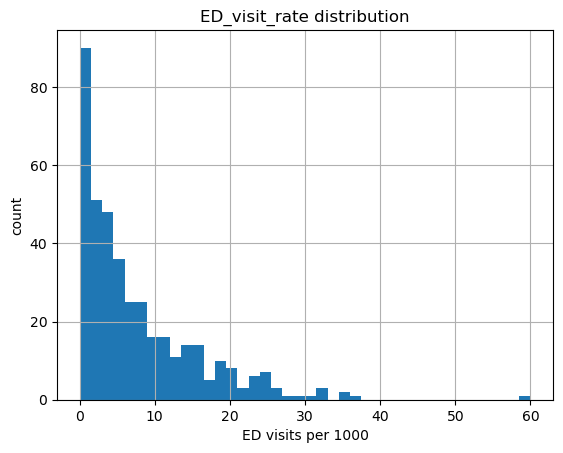

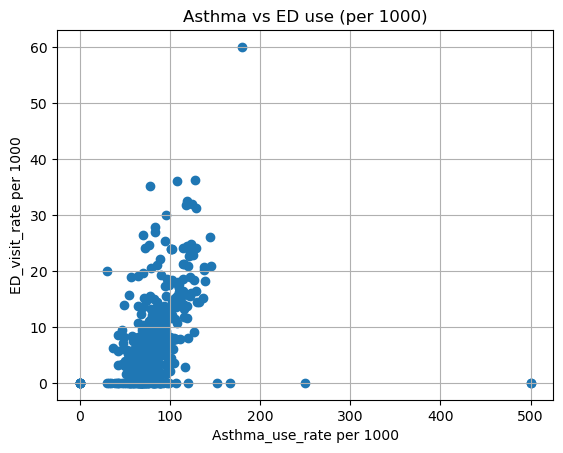

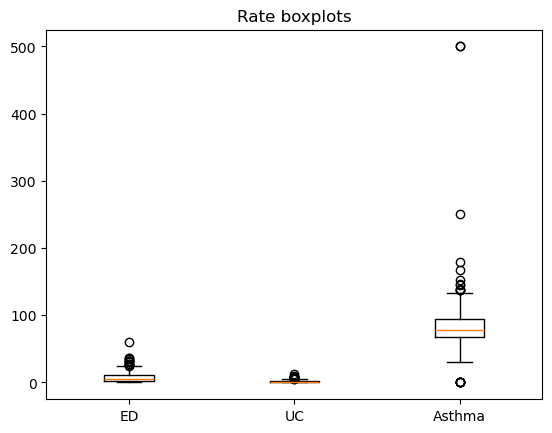

In [14]:
import matplotlib.pyplot as plt

# distribution of ED_visit_rate
plt.figure()
df['ED_visit_rate'].hist(bins=40)
plt.title('ED_visit_rate distribution')
plt.xlabel('ED visits per 1000'); plt.ylabel('count')

# scatter ED_visit_rate vs Asthma_use_rate
plt.figure()
plt.scatter(df['Asthma_use_rate'], df['ED_visit_rate'])
plt.xlabel('Asthma_use_rate per 1000'); plt.ylabel('ED_visit_rate per 1000')
plt.title('Asthma vs ED use (per 1000)')
plt.grid(True)

# boxplot for rates to identify outliers
plt.figure()
plt.boxplot([df['ED_visit_rate'].dropna(), df['UC_visit_rate'].dropna(), df['Asthma_use_rate'].dropna()],
            labels=['ED','UC','Asthma'])
plt.title('Rate boxplots')
plt.show()


In [15]:
# log transform (add 1 to avoid log(0))
df['log_ED_visit_rate'] = np.log1p(df['ED_visit_rate'])
df['log_Asthma_use_rate'] = np.log1p(df['Asthma_use_rate'])

# winsorize extreme rates (example: cap at 99th percentile)
for col in ['ED_visit_rate','UC_visit_rate','Asthma_use_rate','Encounters_per_1000']:
    upper = df[col].quantile(0.99)
    df[col+'_win'] = np.minimum(df[col], upper)


In [16]:
# normalize components (min-max) before combining
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cols_for_index = ['ED_visit_rate', 'ED_hosp_to_ED_ratio', 'Asthma_use_rate', 'Encounters_per_1000']
df[cols_for_index] = df[cols_for_index].fillna(0)
df[['c1','c2','c3','c4']] = scaler.fit_transform(df[cols_for_index])

# weighted sum
df['High_risk_index'] = 0.4*df['c1'] + 0.3*df['c2'] + 0.2*df['c3'] + 0.1*df['c4']

# define tiers
df['risk_tier'] = pd.qcut(df['High_risk_index'], q=4, labels=['Low','Medium','High','Very High'])


In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = ['ED_visit_rate','UC_visit_rate','ED_hosp_to_ED_ratio','Asthma_use_rate']
X = df[features].fillna(0).values
X = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42).fit(X)
df['cluster'] = kmeans.labels_
# profile clusters
df.groupby('cluster')[features].median()


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


,ED_visit_rate,UC_visit_rate,ED_hosp_to_ED_ratio,Asthma_use_rate
cluster,,,,
0,3.225840,0.000000,0.0,73.376784
1,15.564202,2.751032,0.5,101.796407
2,0.000000,0.000000,1000000.0,80.563948
3,0.000000,0.000000,0.0,500.000000


In [18]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.02, random_state=42)
df['anomaly_score'] = iso.fit_predict(X)   # -1 anomaly, 1 normal
anomalies = df[df['anomaly_score']==-1]


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df[features].fillna(0)
y = (df['High_risk_index'] > df['High_risk_index'].quantile(0.75)).astype(int)  # binary target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      1.00      0.98        55
           1       1.00      0.92      0.96        25

    accuracy                           0.97        80
   macro avg       0.98      0.96      0.97        80
weighted avg       0.98      0.97      0.97        80



In [20]:
importances = rf.feature_importances_
for f, imp in sorted(zip(features, importances), key=lambda x: -x[1]):
    print(f, imp)


ED_visit_rate 0.6787267141583128
Asthma_use_rate 0.19371606980652548
ED_hosp_to_ED_ratio 0.10935923077859763
UC_visit_rate 0.018197985256563985


In [21]:
summary = df[['Census_tract','ED_visit_rate','ED_hosp_rate','UC_visit_rate','Asthma_use_rate','High_risk_index','risk_tier','cluster']]
summary.to_csv('tract_summary.csv', index=False)


✅ Data loaded successfully!

Shape: (398, 6)

--- Columns ---
['Census_tract', 'ED_visits', 'ED_hosp', 'UC_visits', 'Asthma_use', 'Total_members']

--- Preview ---
   Census_tract  ED_visits  ED_hosp  UC_visits  Asthma_use  Total_members
0   42003010300          2        0          0           6             83
1   42003020100         32       19          3         223           2114
2   42003020300          0        0          0           2             48
3   42003030500         11        3          3          61            422
4   42003040200          2        1          1          18            138

--- Missing Values ---
ED_visits        0
ED_hosp          0
UC_visits        0
Asthma_use       0
Total_members    0
dtype: int64

--- Descriptive Stats ---
        ED_visits     ED_hosp   UC_visits  Asthma_use  Total_members
count  398.000000  398.000000  398.000000  398.000000     398.000000
mean     3.241206    1.628141    0.645729   38.211055     466.160804
std      3.867726    2.520

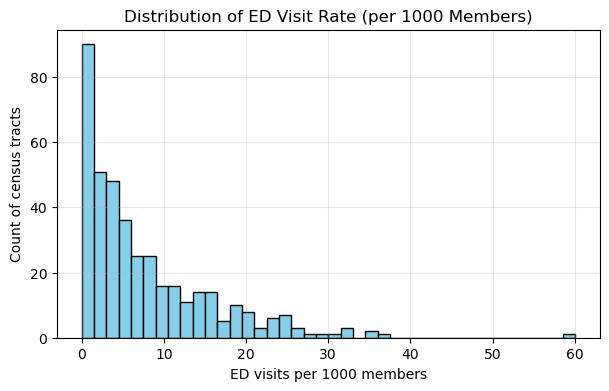


✅ Pipeline complete! feature created and printed successfully


In [23]:

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the Dataset
file_path = "dataset_asthma-2017.csv"
df = pd.read_csv(file_path)

# Initial Inspection
print("✅ Data loaded successfully!\n")
print("Shape:", df.shape)
print("\n--- Columns ---")
print(df.columns.tolist())
print("\n--- Preview ---")
print(df.head())


# Basic Cleaning
#Remove whitespace from column names (in case of hidden spaces)
df.columns = df.columns.str.strip()

# Define expected numeric columns
num_cols = ['ED_visits', 'ED_hosp', 'UC_visits', 'Asthma_use', 'Total_members']

# Convert to numeric safely (if any non-numeric values exist)
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')


#Check Missing & Invalid Values

print("\n--- Missing Values ---")
print(df[num_cols].isnull().sum())

# Drop rows where Total_members is missing or zero (invalid denominator)
invalid_count = ((df['Total_members'].isna()) | (df['Total_members'] <= 0)).sum()
if invalid_count > 0:
    print(f"\n⚠️ Found {invalid_count} rows with invalid Total_members (NaN or 0). Dropping them.")
    df = df[(df['Total_members'].notna()) & (df['Total_members'] > 0)]

# Fill remaining missing visit counts with 0 (optional)
df[['ED_visits','ED_hosp','UC_visits','Asthma_use']] = df[['ED_visits','ED_hosp','UC_visits','Asthma_use']].fillna(0)


#Sanity Checks & Basic Stats
print("\n--- Descriptive Stats ---")
print(df[num_cols].describe())

# Check zeros in main count columns
print("\n--- Zero Counts ---")
print((df[num_cols] == 0).sum())


# Feature Engineering
# feature: ED visit rate per 1,000 members
df['ED_visit_rate'] = (df['ED_visits'] / df['Total_members']) * 1000

print("\n--- ✅ New Feature: ED_visit_rate (per 1,000 members) ---")
print(df[['Census_tract', 'ED_visits', 'Total_members', 'ED_visit_rate']].head(10))

# Basic Visualization of the New Feature
plt.figure(figsize=(7,4))
plt.hist(df['ED_visit_rate'], bins=40, color='skyblue', edgecolor='black')
plt.title('Distribution of ED Visit Rate (per 1000 Members)')
plt.xlabel('ED visits per 1000 members')
plt.ylabel('Count of census tracts')
plt.grid(alpha=0.3)
plt.show()


# Save the Cleaned Data 
#output_path = "cleaned_healthcare_data_with_ED_rate.csv"
#df.to_csv(output_path, index=False)

print(f"\n✅ Pipeline complete! feature created and printed successfully")



In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Census_tract   398 non-null    int64
 1   ED_visits      398 non-null    int64
 2   ED_hosp        398 non-null    int64
 3   UC_visits      398 non-null    int64
 4   Asthma_use     398 non-null    int64
 5   Total_members  398 non-null    int64
dtypes: int64(6)
memory usage: 18.8 KB


In [5]:
#Counting the number of null values in each column
df.isnull().sum()

Census_tract     0
ED_visits        0
ED_hosp          0
UC_visits        0
Asthma_use       0
Total_members    0
dtype: int64